In [82]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

from distributions import Distribution, plot_distribution, plot_distributions, EXPERIMENT_PARAMS, color1, color2

sns.set_context('talk')
%config InlineBackend.figure_format='retina'


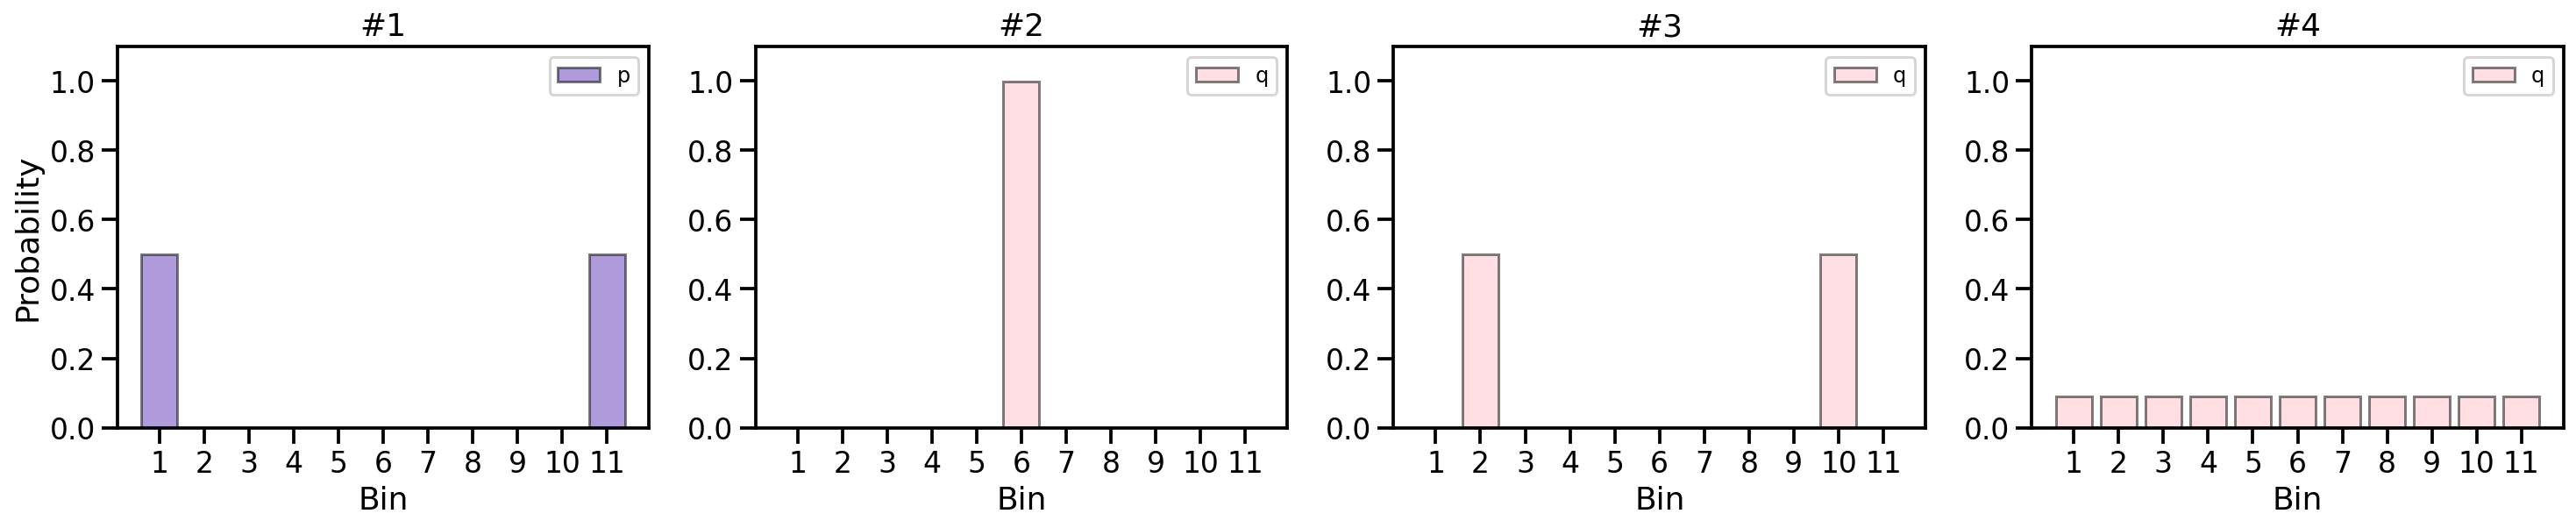

In [83]:
# Ground truth
p1 = Distribution({1: 0.5, 11: 0.5}, eps=EXPERIMENT_PARAMS['eps'])

# Predicted distributions
q1 = Distribution({6: 1}, eps=EXPERIMENT_PARAMS['eps'])
q2 = Distribution({2: 0.5, 10: 0.5}, eps=EXPERIMENT_PARAMS['eps'])
q3 = Distribution({i: 1 / 11 for i in np.arange(1, 12)}, eps=0)

plot_distributions([
    {'p': p1}, {'q': q1}, {'q': q2}, {'q': q3}
])


### Brier Score

In [84]:
def to_cdf(x):
    return np.cumsum(x, axis=-1)


def brier_multi(targets, probs):
    # https://stats.stackexchange.com/questions/403544/how-to-compute-the-brier-score-for-more-than-two-classes
    return np.mean(np.sum((probs - targets)**2, axis=-1))

Compare to ground truth, assuming it is _known_.

In [85]:
print('Brier score for p1: ', brier_multi(p1.probs, p1.probs))
print('Brier score for q1: ', brier_multi(p1.probs, q1.probs))
print('Brier score for q2: ', brier_multi(p1.probs, q2.probs))
print('Brier score for q3: ', brier_multi(p1.probs, q3.probs))

Brier score for p1:  0.0
Brier score for q1:  1.4965797333333337
Brier score for q2:  0.997557049382716
Brier score for q3:  0.4080915202020203


Compare to _samples_ from ground truth (what we would _observe_).

In [86]:
p1_samples = p1.sample_ohe(1000)

print('Brier score for p1: ', brier_multi(p1_samples, p1.probs))
print('Brier score for q1: ', brier_multi(p1_samples, q1.probs))
print('Brier score for q2: ', brier_multi(p1_samples, q2.probs))
print('Brier score for q3: ', brier_multi(p1_samples, q3.probs))

Brier score for p1:  0.5029969444444443
Brier score for q1:  1.9978011000000002
Brier score for q2:  1.4977796111111117
Brier score for q3:  0.9090909090909086


### Discrete Ranked Probability Score

In [87]:
def rps(targets, probs):
    targets = to_cdf(targets)
    probs = to_cdf(probs)
    return np.mean((probs - targets)**2, axis=-1).mean()

Compare to ground truth, assuming it is known.

In [88]:
print('RPS for p1: ', rps(p1.probs, p1.probs))
print('RPS for q1: ', rps(p1.probs, q1.probs))
print('RPS for q2: ', rps(p1.probs, q2.probs))
print('RPS for q3: ', rps(p1.probs, q3.probs))

RPS for p1:  0.0
RPS for q1:  0.22674777845117847
RPS for q2:  0.045343502244668925
RPS for q3:  0.06183204851545767


Compare to _samples_ from ground truth (what we would observe).

In [89]:
p1_samples = p1.sample_ohe(1000)

print('RPS for p1: ', rps(p1_samples, p1.probs))
print('RPS for q1: ', rps(p1_samples, q1.probs))
print('RPS for q2: ', rps(p1_samples, q2.probs))
print('RPS for q3: ', rps(p1_samples, q3.probs))

RPS for p1:  0.2272728198653198
RPS for q1:  0.4542728272727272
RPS for q2:  0.2727071200897867
RPS for q3:  0.2892561983471075


### Discrete Ranked Probability Score, via paper

In [90]:
def crps_v2(targets, probs):

    targets_cdf = to_cdf(targets)
    probs_cdf = to_cdf(probs)
    
    t1 = probs_cdf ** 2
    t2 = (1 - probs_cdf) ** 2

    alpha = np.where(targets_cdf == 1, 0, 1)
    beta = targets_cdf

    return (alpha * t1 + beta * t2).mean()


In [91]:
p1_samples = p1.sample_ohe(1000)

print('RPS for p1: ', rps(p1_samples, p1.probs))
print('RPS for q1: ', rps(p1_samples, q1.probs))
print('RPS for q2: ', rps(p1_samples, q2.probs))
print('RPS for q3: ', rps(p1_samples, q3.probs))

print('\n')

print('crps_v3 for p1: ', crps_v2(p1_samples, p1.probs).mean())
print('crps_v3 for q1: ', crps_v2(p1_samples, q1.probs).mean())
print('crps_v3 for q2: ', crps_v2(p1_samples, q2.probs).mean())
print('crps_v3 for q3: ', crps_v2(p1_samples, q3.probs).mean())

RPS for p1:  0.22727260774410768
RPS for q1:  0.4540002090909091
RPS for q2:  0.2726161099887766
RPS for q3:  0.28908264462809924


crps_v3 for p1:  0.22727260774410776
crps_v3 for q1:  0.4540002090909091
crps_v3 for q2:  0.27261610998877667
crps_v3 for q3:  0.2890826446280992


### CRPS via decomposition

In [92]:
def crps_via_decomp(targets, probs):

    targets_cdf = to_cdf(targets)
    probs_cdf = to_cdf(probs)

    alpha = np.where(targets_cdf == 1, 0, 1)
    beta = targets_cdf

    alpha_bar = alpha.mean(axis=0)
    beta_bar = beta.mean(axis=0)

    o_bar = beta_bar / (alpha_bar + beta_bar)

    reli = (o_bar - probs_cdf) ** 2
    crps_pot = o_bar * (1 - o_bar)

    reli = reli.mean()
    crps_pot = crps_pot.mean()    
    rp_score = reli + crps_pot

    return rp_score, reli, crps_pot

In [93]:
print('rps for p1: ', rps(p1_samples, p1.probs))
print('rps for q1: ', rps(p1_samples, q1.probs))
print('rps for q2: ', rps(p1_samples, q2.probs))
print('rps for q3: ', rps(p1_samples, q3.probs))

print('\n')

print('crps_via_decomp for p1: ', crps_via_decomp(p1_samples, p1.probs))
print('crps_via_decomp for q1: ', crps_via_decomp(p1_samples, q1.probs))
print('crps_via_decomp for q2: ', crps_via_decomp(p1_samples, q2.probs))
print('crps_via_decomp for q3: ', crps_via_decomp(p1_samples, q3.probs))

rps for p1:  0.22727260774410768
rps for q1:  0.4540002090909091
rps for q2:  0.2726161099887766
rps for q3:  0.28908264462809924


crps_via_decomp for p1:  (0.22727260774541902, 0.00042815354955016456, 0.22684445419586885)
crps_via_decomp for q1:  (0.45400021077615743, 0.22715575658028858, 0.22684445419586885)
crps_via_decomp for q2:  (0.2726161105513753, 0.04577165635550646, 0.22684445419586885)
crps_via_decomp for q3:  (0.2890826457009591, 0.062238191505090266, 0.22684445419586885)


### Brier Score via Decomposition
First, implement via a for loop.

In [94]:
def brier_for_loop(targets, probs):
    total = 0
    for (target_example, prob_example) in zip(targets, probs):
        for target_example_class, prob_example_class in zip(target_example, prob_example):
            total += (prob_example_class - target_example_class) ** 2
    return total / len(targets)


def brier_for_loop_v2(targets, probs):
    # Swap the for loops (iterate over the classes in outer loop)
    total = 0
    for target_class, prob_class in zip(targets.T, probs.T):
        for (target_class_example, prob_class_example) in zip(target_class, prob_class):
            total += (prob_class_example - target_class_example) ** 2
    return total / len(targets)

### Single category brier

In [95]:
targets = p1_samples.T # our p
probs = np.broadcast_to(p1.probs.reshape(1, -1), p1_samples.shape).T # Our q

In [96]:
targets_cat1 = targets[0]
probs_cat1 = probs[0]

In [97]:
# Ground truth brier for category 1
((targets_cat1 - probs_cat1) ** 2).mean()

0.25002125

In [98]:
df_tmp = pd.DataFrame({'p': targets_cat1, 'q': probs_cat1})
df_tmp = df_tmp.assign(qbin=pd.cut(df_tmp.q, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))

df_tmp_agg = df_tmp.groupby('qbin').agg({'p': ['mean', 'count']}).reset_index()

In [99]:
df_tmp

,p,q,qbin
0,1.0,0.4995,"(0.4, 0.5]"
1,1.0,0.4995,"(0.4, 0.5]"
2,1.0,0.4995,"(0.4, 0.5]"
3,1.0,0.4995,"(0.4, 0.5]"
4,1.0,0.4995,"(0.4, 0.5]"
...,...,...,...
995,0.0,0.4995,"(0.4, 0.5]"
996,0.0,0.4995,"(0.4, 0.5]"
997,0.0,0.4995,"(0.4, 0.5]"
998,0.0,0.4995,"(0.4, 0.5]"


In [100]:
df_tmp_agg

qbin      p      
                mean count
0  (0.0, 0.1]    NaN     0
1  (0.1, 0.2]    NaN     0
2  (0.2, 0.3]    NaN     0
3  (0.3, 0.4]    NaN     0
4  (0.4, 0.5]  0.521  1000
5  (0.5, 0.6]    NaN     0
6  (0.6, 0.7]    NaN     0
7  (0.7, 0.8]    NaN     0
8  (0.8, 0.9]    NaN     0
9  (0.9, 1.0]    NaN     0

In [101]:
reliability_list = []
for idx, row in df_tmp_agg.iterrows():
    bin_target_mean = row[('p', 'mean')]
    bin_count = row[('p', 'count')]
    qbin_ = row['qbin']

    # Get error for all predictions in this bin
    df_tmp_in_this_bin = df_tmp[df_tmp.qbin == qbin_[0]]

    reliability_bin = ((df_tmp_in_this_bin.q - bin_target_mean) ** 2).sum() 

    reliability_list.append(reliability_bin)

reliability = np.sum(reliability_list) / len(targets_cat1)
reliability

0.00046225118923263765

In [102]:
# Iterate over k bins
resolution_list = []
weight_list = []

target_mean = df_tmp.p.mean()

for idx, row in df_tmp_agg[df_tmp_agg[('p', 'mean')].notnull()].iterrows():

    bin_target_mean = row[('p', 'mean')]
    bin_count = row[('p', 'count')]

    resolution_bin = ((bin_target_mean - target_mean) ** 2)
    resolution_list.append(resolution_bin)
    weight_list.append(bin_count)

resolution = np.average(resolution_list, weights=weight_list)
resolution

0.0

In [103]:
# Uncertainty
targets_cat1.mean() * (1 - targets_cat1.mean())

0.24955899883842392

In [104]:
0.2494240005264281 + 0.0006002494626046428 # this matches ground truth brier for category 1

0.2500242499890327

In [105]:
def brier_full_decomp(targets, probs):

    targets = targets.T 
    probs = probs.T 

    full_reliability_list = []
    full_resolution_list = []
    full_uncertainty_list = []

    for i in range(len(targets)): # Iterate over target bins
        
        targets_cati = targets[i]   
        probs_cati = probs[i]

        df_tmp = pd.DataFrame({'p': targets_cati, 'q': probs_cati})
        df_tmp = df_tmp.assign(qbin=pd.cut(df_tmp.q, bins=np.arange(0,1.01, 0.01))) # Binning predicted value
        df_tmp_agg = df_tmp.groupby('qbin').agg({'p': ['mean', 'count']}).reset_index() # grouping by predicted value

        # Reliability
        reliability_list = []
        for _, row in df_tmp_agg.iterrows():
            bin_target_mean = row[('p', 'mean')]
            bin_count = row[('p', 'count')]
            qbin_ = row['qbin']

            # Get error for all predictions in this bin
            df_tmp_in_this_bin = df_tmp[df_tmp.qbin == qbin_[0]] 
            reliability_bin = ((df_tmp_in_this_bin.q - bin_target_mean) ** 2).sum() 

            reliability_list.append(reliability_bin)

        reliability = np.sum(reliability_list) / len(targets_cati)
        full_reliability_list.append(reliability)

        # Resolution
        target_mean = df_tmp.p.mean()
        resolution_list = []
        weight_list = []
        for _, row in df_tmp_agg[df_tmp_agg[('p', 'mean')].notnull()].iterrows():
            bin_target_mean = row[('p', 'mean')]
            bin_count = row[('p', 'count')]

            resolution_bin = ((bin_target_mean - target_mean) ** 2)
            
            resolution_list.append(resolution_bin)
            weight_list.append(bin_count)
        
        if len(resolution_list) > 0:
            resolution = np.average(resolution_list, weights=weight_list)
            full_resolution_list.append(resolution)

        # Uncertainty
        uncertainty = targets_cati.mean() * (1 - targets_cati.mean())
        full_uncertainty_list.append(uncertainty)

    return (
        np.sum(full_reliability_list) - np.sum(full_resolution_list) + np.sum(full_uncertainty_list), 
        np.sum(full_reliability_list),
        np.sum(full_resolution_list),
        np.sum(full_uncertainty_list)
    )

In [106]:
print('Brier score for p1: ', brier_multi(p1_samples, p1.probs))
print('Brier score for q1: ', brier_multi(p1_samples, q1.probs))
print('Brier score for q2: ', brier_multi(p1_samples, q2.probs))
print('Brier score for q3: ', brier_multi(p1_samples, q3.probs))
print('\n')
print('Brier score for p1: ', brier_full_decomp(p1_samples, np.broadcast_to(p1.probs.reshape(1, -1), p1_samples.shape)))
print('Brier score for q1: ', brier_full_decomp(p1_samples, np.broadcast_to(q1.probs.reshape(1, -1), p1_samples.shape)))
print('Brier score for q2: ', brier_full_decomp(p1_samples, np.broadcast_to(q2.probs.reshape(1, -1), p1_samples.shape)))
print('Brier score for q3: ', brier_full_decomp(p1_samples, np.broadcast_to(q3.probs.reshape(1, -1), p1_samples.shape)))


Brier score for p1:  0.5009993888888888
Brier score for q1:  1.9978011000000002
Brier score for q2:  1.4987783888888897
Brier score for q3:  0.9090909090909086


Brier score for p1:  (0.5009993889492504, 0.000925390713830117, 0.0, 0.5000739982354203)
Brier score for q1:  (1.9978011129195166, 1.4977271146840963, 0.0, 0.5000739982354203)
Brier score for q2:  (1.4987784018081183, 0.998704403572698, 0.0, 0.5000739982354203)
Brier score for q3:  (0.909090919663537, 0.40901692142811663, 0.0, 0.5000739982354203)


### Back to CRPS

In [107]:
def crps_full_decomp(targets, probs):

    targets = to_cdf(targets)
    probs = to_cdf(probs)
    num_classes = targets.shape[-1]

    rps_result, reli, reso, unc = [x.mean() for x in brier_full_decomp(targets, probs)]
    return  rps_result / num_classes, reli / num_classes, reso / num_classes, unc / num_classes # TODO: Don't hard code class number here


In [108]:
print('RPS for p1: ', rps(p1_samples, p1.probs))
print('RPS for q1: ', rps(p1_samples, q1.probs))
print('RPS for q2: ', rps(p1_samples, q2.probs))
print('RPS for q3: ', rps(p1_samples, q3.probs))

print('\n')

# Dividing by 11 will yield the rps
print('brier_multi for p1: ', brier_multi(to_cdf(p1_samples), to_cdf(p1.probs)).mean() / 11)
print('brier_multi for q1: ', brier_multi(to_cdf(p1_samples), to_cdf(q1.probs)).mean() / 11)
print('brier_multi for q2: ', brier_multi(to_cdf(p1_samples), to_cdf(q2.probs)).mean() / 11)
print('brier_multi for q3: ', brier_multi(to_cdf(p1_samples), to_cdf(q3.probs)).mean() / 11)

RPS for p1:  0.22727260774410768
RPS for q1:  0.4540002090909091
RPS for q2:  0.2726161099887766
RPS for q3:  0.28908264462809924


brier_multi for p1:  0.22727260774410765
brier_multi for q1:  0.4540002090909091
brier_multi for q2:  0.2726161099887766
brier_multi for q3:  0.28908264462809913


In [109]:
print('RPS for p1: ', rps(p1_samples, p1.probs))
print('RPS for q1: ', rps(p1_samples, q1.probs))
print('RPS for q2: ', rps(p1_samples, q2.probs))
print('RPS for q3: ', rps(p1_samples, q3.probs))

print('\n')

print('crps_full_decomp for p1: ', crps_full_decomp(p1_samples, np.broadcast_to(p1.probs.reshape(1, -1), p1_samples.shape)))
print('crps_full_decomp for q1: ', crps_full_decomp(p1_samples, np.broadcast_to(q1.probs.reshape(1, -1), p1_samples.shape)))
print('crps_full_decomp for q2: ', crps_full_decomp(p1_samples, np.broadcast_to(q2.probs.reshape(1, -1), p1_samples.shape)))
print('crps_full_decomp for q3: ', crps_full_decomp(p1_samples, np.broadcast_to(q3.probs.reshape(1, -1), p1_samples.shape)))

RPS for p1:  0.22727260774410768
RPS for q1:  0.4540002090909091
RPS for q2:  0.2726161099887766
RPS for q3:  0.28908264462809924


crps_full_decomp for p1:  (0.22727260774683875, 0.0004281539320724455, 0.0, 0.22684445381476628)
crps_full_decomp for q1:  (0.45400021260076007, 0.22715575878599378, 0.0, 0.22684445381476628)
crps_full_decomp for q2:  (0.2726161111604956, 0.04577165734572932, 0.0, 0.22684445381476628)
crps_full_decomp for q3:  (0.2890826468625345, 0.06223819304776819, 0.0, 0.22684445381476628)


In [110]:
print(p1_samples.shape)
print(np.broadcast_to(p1.probs.reshape(1, -1), p1_samples.shape).shape)

(1000, 11)
(1000, 11)


### Update data to see if resolution is working

In [111]:
# Create 5 ground truth generating distributions
p1 = Distribution({1: 0.5, 11: 0.5}, eps=EXPERIMENT_PARAMS['eps'])
p2 = Distribution({i: 1 / 11 for i in np.arange(1, 12)}, eps=0)
p3 = Distribution({6: 1}, eps=EXPERIMENT_PARAMS['eps'])
p4 = Distribution({3: 0.25, 4: 0.25, 7: 0.25, 6:0.05, 8: 0.1, 9: 0.05, 10: 0.05}, eps=EXPERIMENT_PARAMS['eps'])
p5 = Distribution({1: 0.25, 2: 0.02, 3: 0.4, 5: 0.08, 6:0.05, 8: 0.1, 9: 0.05, 10: 0.05}, eps=EXPERIMENT_PARAMS['eps'])


It looks like there is a bug with rps:

In [112]:
p1_samples = p1.sample_ohe(1000)
p2_samples = p2.sample_ohe(1000)
p3_samples = p3.sample_ohe(1000)
p4_samples = p4.sample_ohe(1000)
p5_samples = p5.sample_ohe(1000)

q1_probs = np.broadcast_to(p1.probs.reshape(1, -1), p1_samples.shape)
q2_probs = np.broadcast_to(p2.probs.reshape(1, -1), p2_samples.shape)
q3_probs = np.broadcast_to(p3.probs.reshape(1, -1), p3_samples.shape)
q4_probs = np.broadcast_to(p4.probs.reshape(1, -1), p4_samples.shape)
q5_probs = np.broadcast_to(p5.probs.reshape(1, -1), p5_samples.shape)

p_samples = np.vstack([p1_samples, p2_samples, p3_samples, p4_samples, p5_samples])
q_probs = np.vstack([q1_probs, q2_probs, q3_probs, q4_probs, q5_probs])


print('RPS: ', rps(p_samples, q_probs))
print('\n')
print('crps_full_decomp: ', crps_full_decomp(p_samples, q_probs))

RPS:  0.12760001330148266


crps_full_decomp:  (0.12759996299597123, 7.644774722938753e-05, 0.03669263330349371, 0.16421614855223554)


In [113]:
p_samples = np.vstack([p1_samples, p2_samples, p3_samples, p4_samples, p5_samples])
q_probs = np.vstack([q2_probs, q5_probs, q4_probs, q1_probs, q3_probs])


print('RPS: ', rps(p_samples, q_probs))

print('\n')
print('crps_full_decomp: ', crps_full_decomp(p_samples, q_probs))

RPS:  0.2180252852849537


crps_full_decomp:  (0.21802443103501734, 0.08769210946199868, 0.03388382697921687, 0.16421614855223554)


See if this issue is also happening with brier:

In [114]:
p_samples = np.vstack([p1_samples, p2_samples, p3_samples, p4_samples, p5_samples])
q_probs = np.vstack([q1_probs, q2_probs, q3_probs, q4_probs, q5_probs])


print('Brier multi: ', brier_multi(p_samples, q_probs))
print('\n')
print('brier_full_decomp: ', brier_full_decomp(p_samples, q_probs))

Brier multi:  0.5938022665007214


brier_full_decomp:  (0.5938236337635543, 0.0005674752093307583, 0.26691935433615593, 0.8601755128903794)


In [115]:
p_samples = np.vstack([p1_samples, p2_samples, p3_samples, p4_samples, p5_samples])
q_probs_ground_truth = np.vstack([q1_probs, q2_probs, q3_probs, q4_probs, q5_probs])
q_probs_wrong_1_off = np.vstack([q2_probs, q1_probs, q3_probs, q4_probs, q5_probs])
q_probs_wrong_2_off = np.vstack([q2_probs, q1_probs, q4_probs, q3_probs, q5_probs])
q_probs_wrong_3_off = np.vstack([q2_probs, q5_probs, q4_probs, q3_probs, q1_probs])


print('crps_full_decomp: ', crps_full_decomp(p_samples, q_probs_ground_truth))
print('crps_full_decomp: ', crps_full_decomp(p_samples, q_probs_wrong_1_off))
print('crps_full_decomp: ', crps_full_decomp(p_samples, q_probs_wrong_2_off))
print('crps_full_decomp: ', crps_full_decomp(p_samples, q_probs_wrong_3_off))

crps_full_decomp:  (0.12759996299597123, 7.644774722938753e-05, 0.03669263330349371, 0.16421614855223554)
crps_full_decomp:  (0.15306136779797216, 0.02553785254923034, 0.03669263330349371, 0.16421614855223554)
crps_full_decomp:  (0.18283902742625766, 0.05494966670941084, 0.03632678783538874, 0.16421614855223554)
crps_full_decomp:  (0.1971965699835091, 0.06829174521720154, 0.035311323785927995, 0.16421614855223554)


### Speed up the decomp

In [116]:
def brier_full_decomp_v1(targets, probs):

    targets = targets.T 
    probs = probs.T 

    full_reliability_list = []
    full_resolution_list = []
    full_uncertainty_list = []

    for i in range(len(targets)):
        
        targets_cati = targets[i]   
        probs_cati = probs[i]

        df_tmp = pd.DataFrame({'p': targets_cati, 'q': probs_cati})
        df_tmp = df_tmp.assign(qbin=pd.cut(df_tmp.q, bins=np.arange(0,1.01, 0.01)))
        df_tmp_agg = df_tmp.groupby('qbin').agg({'p': ['mean', 'count']}).reset_index()

        # Reliability
        reliability_list = []
        for _, row in df_tmp_agg.iterrows():
            bin_target_mean = row[('p', 'mean')]
            bin_count = row[('p', 'count')]
            qbin_ = row['qbin']

            # Get error for all predictions in this bin
            df_tmp_in_this_bin = df_tmp[df_tmp.qbin == qbin_[0]] 
            reliability_bin = ((df_tmp_in_this_bin.q - bin_target_mean) ** 2).sum() 

            reliability_list.append(reliability_bin)

        reliability = np.sum(reliability_list) / len(targets_cati)
        full_reliability_list.append(reliability)

        # Resolution
        target_mean = df_tmp.p.mean()
        resolution_list = []
        weight_list = []
        for _, row in df_tmp_agg[df_tmp_agg[('p', 'mean')].notnull()].iterrows():
            bin_target_mean = row[('p', 'mean')]
            bin_count = row[('p', 'count')]

            resolution_bin = ((bin_target_mean - target_mean) ** 2)
            
            resolution_list.append(resolution_bin)
            weight_list.append(bin_count)
        
        if len(resolution_list) > 0:
            resolution = np.average(resolution_list, weights=weight_list)
            full_resolution_list.append(resolution)

        # Uncertainty
        uncertainty = targets_cati.mean() * (1 - targets_cati.mean())
        full_uncertainty_list.append(uncertainty)

    return (
        np.sum(full_reliability_list) - np.sum(full_resolution_list) + np.sum(full_uncertainty_list), 
        np.sum(full_reliability_list),
        np.sum(full_resolution_list),
        np.sum(full_uncertainty_list)
    )


def crps_full_decomp(targets, probs):
    targets = to_cdf(targets)
    probs = to_cdf(probs)
    num_classes = targets.shape[-1]

    rps_result, reli, reso, unc = [x.mean() for x in brier_full_decomp_v1(targets, probs)]
    return  rps_result / num_classes, reli / num_classes, reso / num_classes, unc / num_classes 


In [117]:
p_samples = np.vstack([p1_samples, p2_samples, p3_samples, p4_samples, p5_samples])
p_samples = np.vstack([p_samples for _ in range(1000)])

q_probs = np.vstack([q1_probs, q2_probs, q3_probs, q4_probs, q5_probs])
q_probs = np.vstack([q_probs for _ in range(1000)])

print(p_samples.shape)

(5000000, 11)


In [118]:
%%time
print('RPS: ', rps(p_samples, q_probs))


RPS:  0.1276000133014827
CPU times: user 506 ms, sys: 188 ms, total: 694 ms
Wall time: 707 ms


In [119]:
%%time
print('crps_full_decomp: ', crps_full_decomp(p_samples, q_probs))

crps_full_decomp:  (0.12759996299597123, 7.644774722938753e-05, 0.03669263330349371, 0.16421614855223554)
CPU times: user 5.52 s, sys: 892 ms, total: 6.42 s
Wall time: 6.42 s


### How to speed up brier decomposition
1. We need to _iterate_ over target bins (groupby `target_binned`)
2. For each group, will need to apply a udf 


In [74]:
(760 * 24 * 1900) / 28

1237714.2857142857